In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
import unicodedata
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib


startup script successful


In [2]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

from nltk.stem import WordNetLemmatizer
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1

In [3]:
from nltk.corpus import stopwords
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']

In [4]:
crunch_data=pd.read_csv('overall_company_list.csv')
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv')
# unify the column name
kickstart_data.rename(columns={'description':'Description'},inplace=True)
angellist_data.rename(columns={'product_desc':'Description'},inplace=True)
#merge data
merge_data=crunch_data.append([kickstart_data,angellist_data])
# remove \n from descriptions
merge_data['Description']=merge_data['Description'].str.replace('\n',' ')
# merge_data['Description']=merge_data['Description'].str.replace('\\',' ')

merge_data=merge_data.dropna(subset=['Description'])
# turn into graphlab
# startup_data=graphlab.SFrame(merge_data['Description'])
# startup_data.rename({'X1':'Description'})

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=3000,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=stop_list)
tfidf = tfidf_vectorizer.fit_transform(merge_data['Description'])

In [6]:
nmf = NMF(n_components=15, random_state=1, 
          alpha=.1, l1_ratio=.2, max_iter=5000).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
topic_feature=nmf.transform(tfidf)
topic_feature_norm=normalize(topic_feature)

# Plot the topics 

Topic #0:
data big science driven visualization analysis platform insight enterprise cloud
Topic #1:
mobile application app web apps user development device game developer
Topic #2:
technology develops startup focused information firm design healthcare using generation
Topic #3:
social medium network content brand engagement networking discovery audience management
Topic #4:
intelligence artificial research market enterprise competitive human powered ai cyber
Topic #5:
analytics predictive provides retail advanced tool healthcare financial sale industry
Topic #6:
real time estate insight analysis place delivers information feedback news
Topic #7:
user product online customer experience video com use create get
Topic #8:
service cloud provider provides offer market research consulting financial demand
Topic #9:
company research development market focused digital inc venture consulting focus
Topic #10:
based location cloud user offer game sharing app saas interest
Topic #11:
business sma

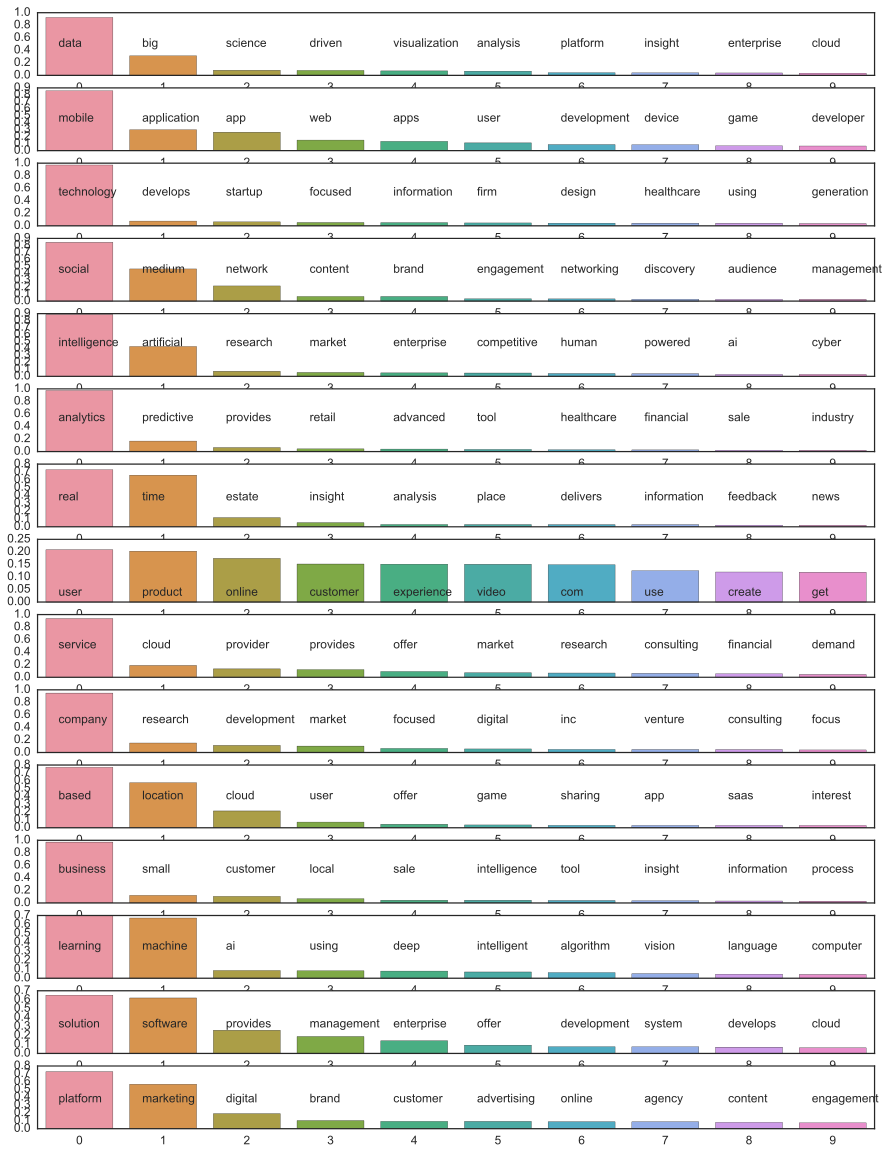

In [9]:
fig=figure(figsize=(15,20))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(nmf,tfidf_feature_names,i)

# Cluster the companies 

In [7]:
import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])

In [8]:
>>> from sklearn import metrics
>>> from sklearn.metrics import pairwise_distances

In [9]:
def plot_cluster(model, features, tsne_features, feature_names, nmf_model=nmf):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
    

In [10]:
def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']


## K-mans Clustering

### withoug normalization

In [12]:
n_clusters=10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(topic_feature)
metrics.calinski_harabaz_score(topic_feature, kmeans.labels_) 

1975.7717115955766

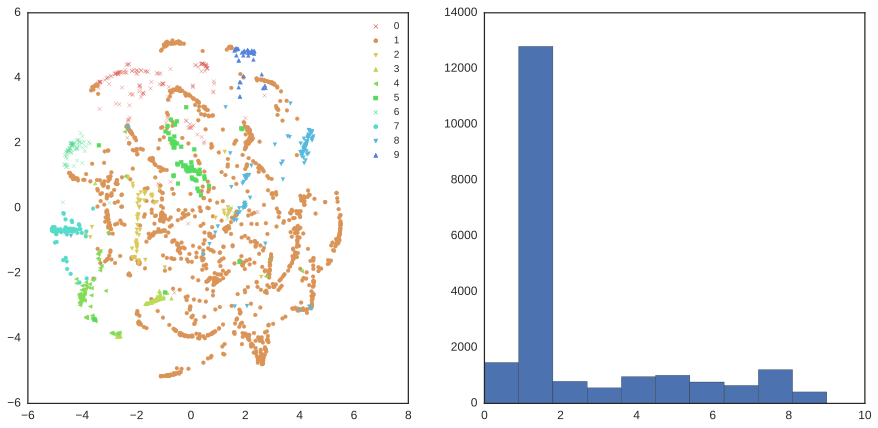

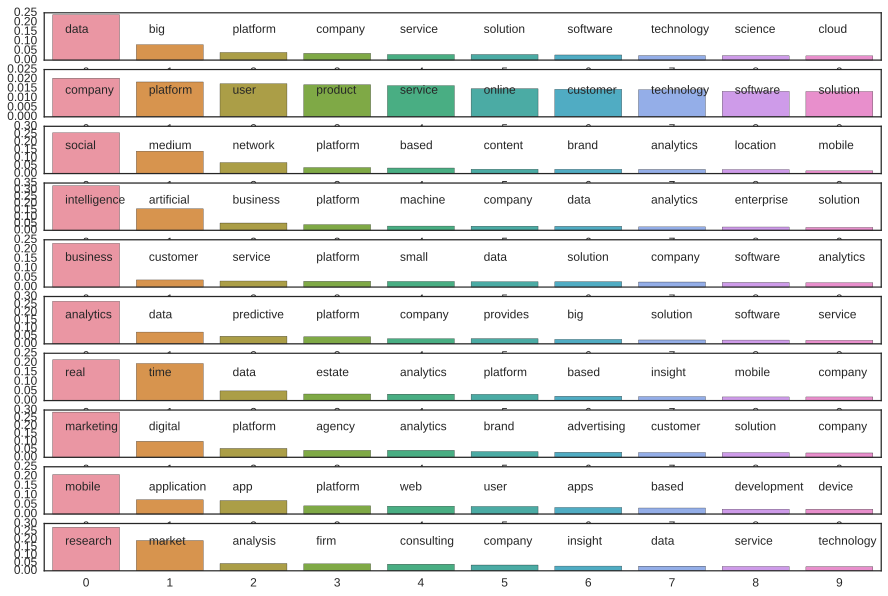

In [13]:
plot_cluster(kmeans, topic_feature, topic_feature, tfidf_feature_names)

In [161]:
# look at one cluster 'artifical intellegence'

In [14]:
print_cluster_member(kmeans, 3, merge_data, 15)

number of companies in this class: 556
company ID: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
company ID: 21
Advanced medication adherence solutions powered by artificial intelligence
company ID: 27
FirstFuel provides an analytics based customer intelligence platform for utilities and energy service providers
company ID: 39
Meta is an Artificial Intelligence that continuously maps and monitors the universe of science, as well as its future horizons.
company ID: 45
Profitero is a next-generation pricing intelligence service for retailers and manufacturers
company ID: 48
WireX Systems provides cyber intelligence solutions.
company ID: 66
AYLIEN is an Artificial Intelligence startup, focused on creating technologies that help machines understand humans better.
company ID: 94
Pick1 offers a survey and marketing intelligence suite to deliver actionable data for businesses.
company ID: 98
Blue Health Intelligence accesses th

### with normalization

In [164]:
# normalize the topic feature vector is equivalent to use cosine distance

In [15]:
n_clusters=15
kmeans_norm = KMeans(n_clusters=n_clusters, random_state=0).fit(topic_feature_norm)
metrics.calinski_harabaz_score(topic_feature_norm, kmeans_norm.labels_) 

3555.3367802345647

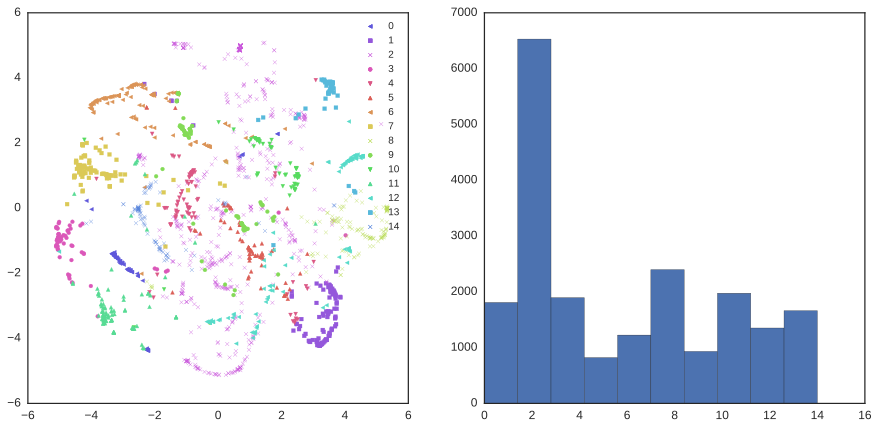

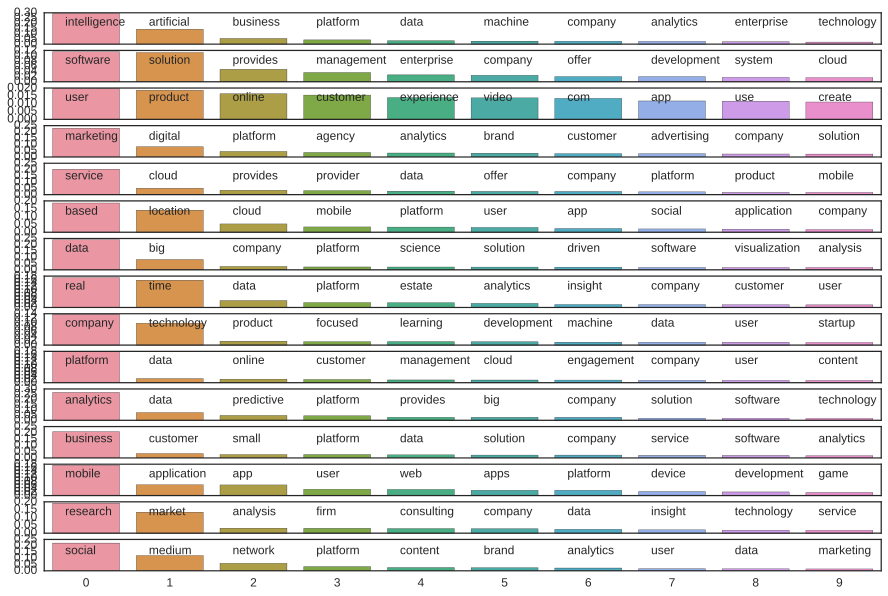

In [16]:
plot_cluster(kmeans_norm, topic_feature, topic_feature_norm, tfidf_feature_names)

In [17]:
print_cluster_member(kmeans_norm, 0, merge_data, 15)

number of companies in this class: 678
company ID: 2
Sumo Logic, a log management and analytics service, transforms big data into sources of operations, security and compliance intelligence.
company ID: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
company ID: 21
Advanced medication adherence solutions powered by artificial intelligence
company ID: 27
FirstFuel provides an analytics based customer intelligence platform for utilities and energy service providers
company ID: 39
Meta is an Artificial Intelligence that continuously maps and monitors the universe of science, as well as its future horizons.
company ID: 43
StreetLight Data delivers next-generation geospatial business intelligence to support critical decisions and improve return on investment.
company ID: 45
Profitero is a next-generation pricing intelligence service for retailers and manufacturers
company ID: 48
WireX Systems provides cyber intelligence solution

## Agglomerative clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
agg= AgglomerativeClustering(n_clusters=15, linkage='ward')
agg.fit(topic_feature_norm)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=15, n_components=None,
            pooling_func=<function mean at 0x10b83b578>)

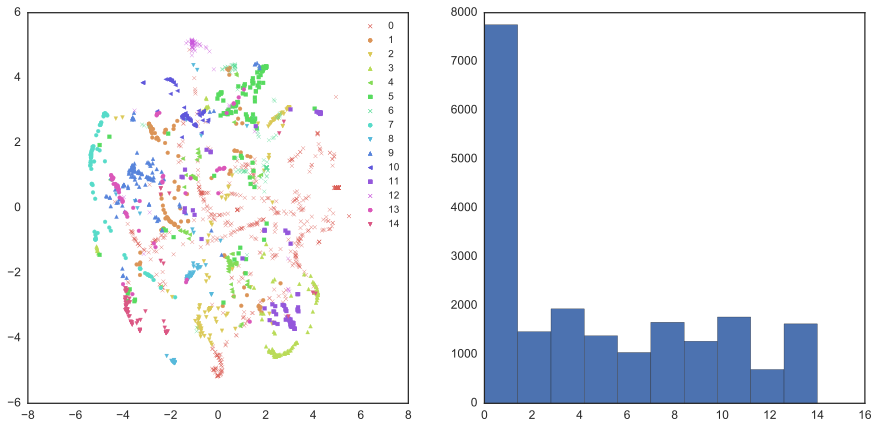

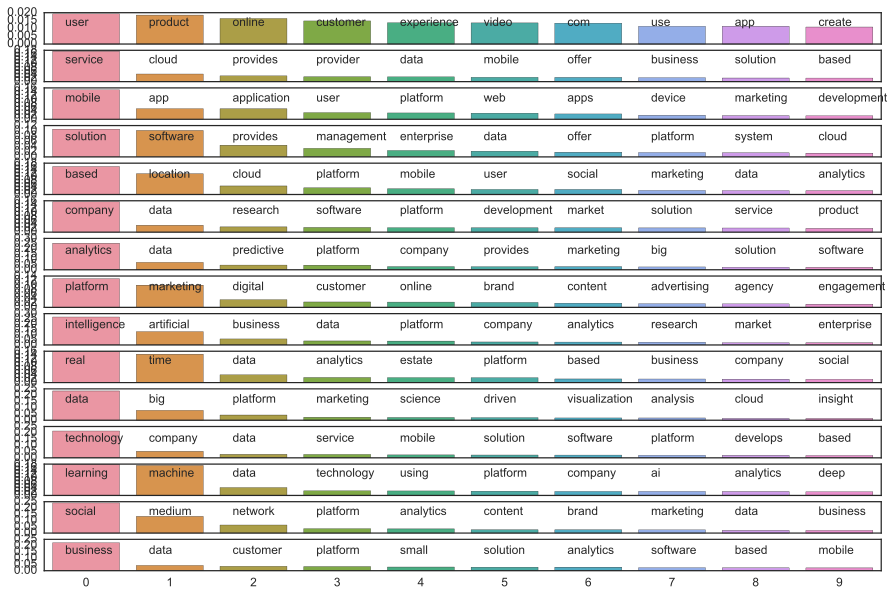

In [13]:
plot_cluster(agg, topic_feature, topic_feature_norm, tfidf_feature_names)

In [29]:
print_cluster_member(agg, 12, merge_data, 200)

number of companies in this class: 693
company ID: 19
Sidecar is machine learning technology that leverages big data to deliver programmatic marketing decisions for e-commerce companies.
company ID: 53
VocalZoom mission to enable Voice control and Voice Authentication. Multifunction Sensors Enable Human Machine communication.
company ID: 70
Google DeepMind is developing learning algorithms that use data or raw experience to better themselves.
company ID: 96
Optimize chip designs with machine learning
company ID: 173
SpeakGlobal makes innovative language learning software with virtual tutors - "The tennis ball machine for English conversation"
company ID: 174
Our vision is to gamify the internet.
company ID: 277
Your message. Your style. ai.type is out to reinvent touchscreen typing.
company ID: 482
AlphaCloud Labs provides a cloud and deep learning-based unstructured data management, collaboration and content analytics platform.
company ID: 489
LoudCloud is a learning ecosystem creatin

In [18]:
from sklearn.neighbors import NearestNeighbors

In [19]:
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=0.4)

In [20]:
def query_company(id, knn_model=neigh, data_set=merge_data, X=topic_feature_norm):
    k=10
    print 'query id:', id
    print data_set.iloc[id]['Description']
    print '-'*50
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print '{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i])
        print  data_set.iloc[indices[0][i]]['Description']
        print 

In [30]:
query_company(3598)

query id: 3598
Self-learning DSP for Mobile
--------------------------------------------------
1st neighbor: id 2968, with distance 0.0
Self-learning DSP for Mobile

2st neighbor: id 12991, with distance 0.0177916124477
A mobile encyclopedia for discovering and learning about craft beer and breweries.

3st neighbor: id 6655, with distance 0.128945906213
Web and Mobile applications, E-Commerce, Machine Learning. http://www.octoleaf.com

4st neighbor: id 6606, with distance 0.128945906213
Web and Mobile applications, E-Commerce, Machine Learning. http://www.octoleaf.com

5st neighbor: id 9067, with distance 0.146368974191
1:1 mobile app engagement fueled by machine learning

6st neighbor: id 4282, with distance 0.166751406307
Egos Ventures develops several innovative mobile apps focusing on Computer Vision, 3D Reconstruction, Deep Learning, and Motion Sensors.

7st neighbor: id 15067, with distance 0.236449461703
A socially curated directory of websites, mobile apps, desktop programs, an

In [31]:
merge_data.iloc[3598]

Categories                                          Big Data, Mobile Advertising
Category Groups                Data and Analytics, Sales and Marketing, Adver...
Closed Date                                                                  NaN
Company Name                                                   Deep Forest Media
Crunchbase Rank                                                           10,010
Description                                         Self-learning DSP for Mobile
Founded Date                                                          2012-01-01
Headquarters Location                       Palo Alto, California, United States
IPO Date                                                                     NaN
Last Equity Funding Amount                                            $1,710,072
Last Funding Amount                                                   $1,710,072
Last Funding Date                                                     2014-12-31
Money Raised at IPO         